In [1]:
import os
import scipy.io as io
from scipy.io import savemat
import librosa
import librosa.display
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from doepy import build
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import platform
import time as tim
import os
import tempfile

from modelisation_physique.guide_onde import simulation

%matplotlib widget

In [7]:
def are_there_oscillations(waveform, epsilon):
    N2_3 = int(len(waveform) / 3)
    criterion = np.mean(np.abs(waveform[N2_3:]))
    return criterion > epsilon

In [8]:
#Paramètres (au hasard pour l'instant):
t_max = 0.3 #durée de la simulation en s
fe = 44100 #Fréquence d'échantillonnage
type_reflection = 'dirac' #type de réflexion au bout du guide, 'dirac' ou 'triangle'
#frac_T : #seulement pour le type 'triangle', définition de la demi-largeur du triangle T/frac_T
L =0.6 #Longueur du cylindre
c =340 #célérité des ondes

# Initial DOE: build initial parameters space
num_samples = 20
parameters = build.space_filling_lhs(
    {"gamma": [0, 1], 
     "zeta": [0, 1]},
    num_samples=num_samples
)

# Create sound samples and associated labels
wave_dataset = np.zeros((num_samples, int(t_max*fe)))
labels = np.zeros(num_samples)
mean_amplitude = np.zeros(num_samples)

for i, x in tqdm(parameters.iterrows()):
    waveform, _ =simulation(t_max, fe, x["gamma"], x["zeta"], type_reflection, L, c, frac_T=10 ,fig=False, sound=False)
    wave_dataset[i] = waveform
    n_1_3 = int(len(waveform)/3)
    mean_amplitude[i] = np.mean(np.abs(waveform[n_1_3:]))
    labels[i] = 1 if are_there_oscillations(waveform, epsilon=0.15) else 0
    
X, y = parameters.to_numpy(), labels

0it [00:00, ?it/s]

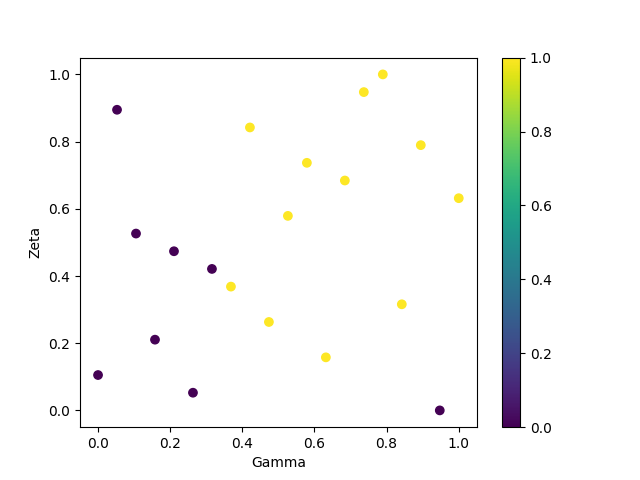

In [9]:
plt.figure()
plt.scatter(parameters["gamma"], parameters["zeta"], c=labels)
plt.xlabel("Gamma")
plt.ylabel("Zeta")
plt.colorbar()
plt.show()

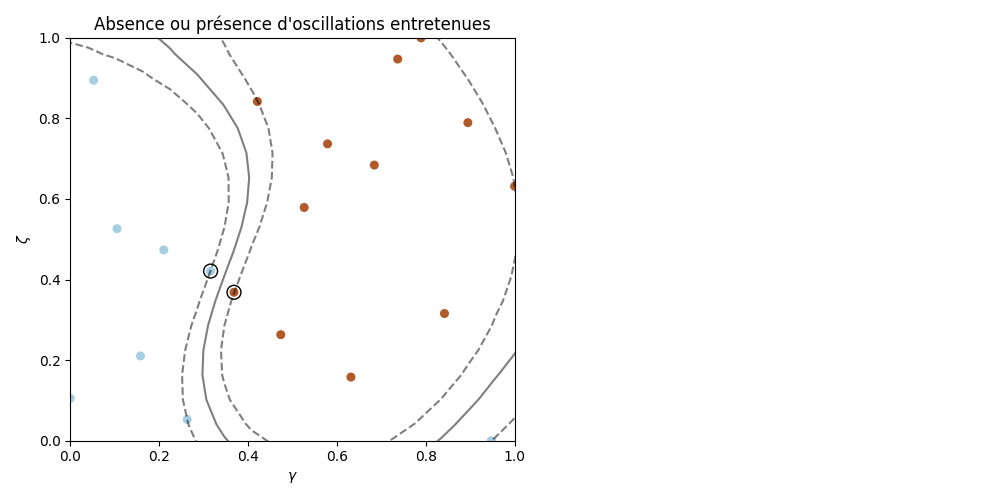

In [10]:
plt.figure(figsize=(10, 5))
for i, C in enumerate([100]):
    # "hinge" is the standard SVM loss
    clf = SVC(C=C, random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    # The support vectors are the samples that lie within the margin
    # boundaries, whose size is conventionally constrained to 1
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["--", "-", "--"],
    )
    plt.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=100,
        linewidth=1,
        facecolors="none",
        edgecolors="k",
    )
    plt.title("Absence ou présence d'oscillations entretenues")
    plt.xlabel(r"$\gamma$")
    plt.ylabel(r"$\zeta$")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
plt.tight_layout()
plt.show()

In [11]:
io.savemat('X_guide_onde.mat', {"X": X})
io.savemat('labels_guide_onde.mat', {"labels_guide_onde": y})